In [1]:
import sys
sys.path.insert(0, '..')

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams.update({'font.size': 16})

import numpy as np

import reference_LFs as refLF
from paus_utils import *

from jpasLAEs.utils import bin_centers

import numpy as np

In [2]:
def load_combined_LF(region_list, NB_list):
    this_hist = None
    eff_vol = 0
    for region_name in region_list:
        for [nb1, nb2] in NB_list:
            LF_name = f'Lya_LF_nb{nb1}-{nb2}_{region_name}'
            pathname = f'/home/alberto/almacen/PAUS_data/Lya_LFs/{LF_name}'
            filename_hist = f'{pathname}/hist_i_mat.npy'

            hist_i_mat = np.load(filename_hist)

            if this_hist is None:
                this_hist = hist_i_mat
            else:
                this_hist += hist_i_mat

    # TODO: add one indent to the next line, and remove the for loop
    for [nb1, nb2] in NB_list:
        eff_vol += Lya_effective_volume(nb1, nb2, region_name) # TODO: Change the area with region_name

    L_bins = np.load(f'{pathname}/LF_L_bins.npy')
    bin_width = [L_bins[i + 1] - L_bins[i] for i in range(len(L_bins) - 1)]

    hist_median = np.percentile(this_hist, 50, axis=0)

    boots_path = f'/home/alberto/almacen/PAUS_data/Lya_LFs/bootstrap_errors'
    yerr_minus = np.load(f'{boots_path}/LF_err_minus_nb{nb1}-{nb2}.npy')
    yerr_plus = np.load(f'{boots_path}/LF_err_plus_nb{nb1}-{nb2}.npy')

    this_LF = hist_median / bin_width / eff_vol
    LF_boots = np.load(f'{boots_path}/median_LF_nb{nb1}-{nb2}.npy')
    # Fix yerr_minus when LF_boots == 0
    yerr_minus[LF_boots == 0] = this_LF[LF_boots == 0]

    this_LF_dict = {
        'LF_bins': bin_centers(L_bins),
        'LF_total': this_LF,
        'LF_total_err': [yerr_minus, yerr_plus],
    }

    return this_LF_dict

In [3]:
# Load the QSO mock to compare
from load_paus_mocks import load_qso_mock
from jpasLAEs.utils import flux_to_mag

source_cats_dir = '/home/alberto/almacen/Source_cats'
mock_path = f'{source_cats_dir}/QSO_PAUS_LAES_2'
mock = load_qso_mock(mock_path)

mock['r_mag'] = flux_to_mag(mock['flx_0'][-4], w_central[-4])

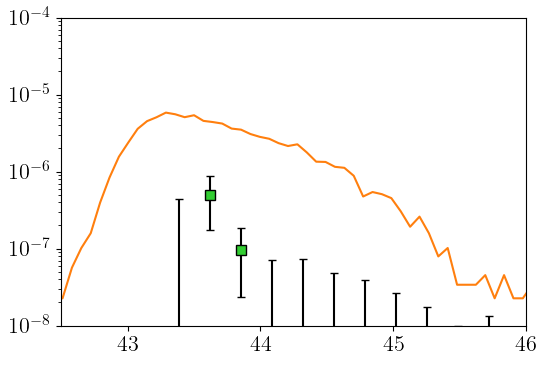

In [4]:
survey_list = ['W3']
# nb_list = [[0, 2], [2, 4], [4, 6], [6, 8],
#            [8, 10], [10, 12], [12, 14], [14, 16]]
nb_list = [[0, 2]]

LyaLF = load_combined_LF(survey_list, nb_list)

# LF of the mock
nb1, nb2 = nb_list[0][0], nb_list[-1][-1]
L_bins = np.linspace(40, 47, 100)
L_bins_c = bin_centers(L_bins)
L_bins_w = L_bins[1] - L_bins[0]
mask_mock = ((NB_z(mock['zspec']) >= nb1)
             & (NB_z(mock['zspec']) <= nb2)
             & (mock['EW0_lya_spec'] > 30)
             & (mock['r_mag'] < 24)
             & (mock['r_mag'] > 17))
mock_LF = np.histogram(mock['L_lya_spec'][mask_mock], L_bins)[0]\
              / L_bins_w / Lya_effective_volume(nb1, nb2, 400)


fig, ax = plt.subplots(figsize=(6, 4))

ax.errorbar(LyaLF['LF_bins'], LyaLF['LF_total'],
            yerr=LyaLF['LF_total_err'],
            fmt='s', ls='', mfc='limegreen', mec='k',
            ms=7, ecolor='k', capsize=3)

ax.plot(L_bins_c, mock_LF)

ax.set(yscale='log',
       xlim=(42.5, 46), ylim=(1e-8, 1e-4))

plt.show()

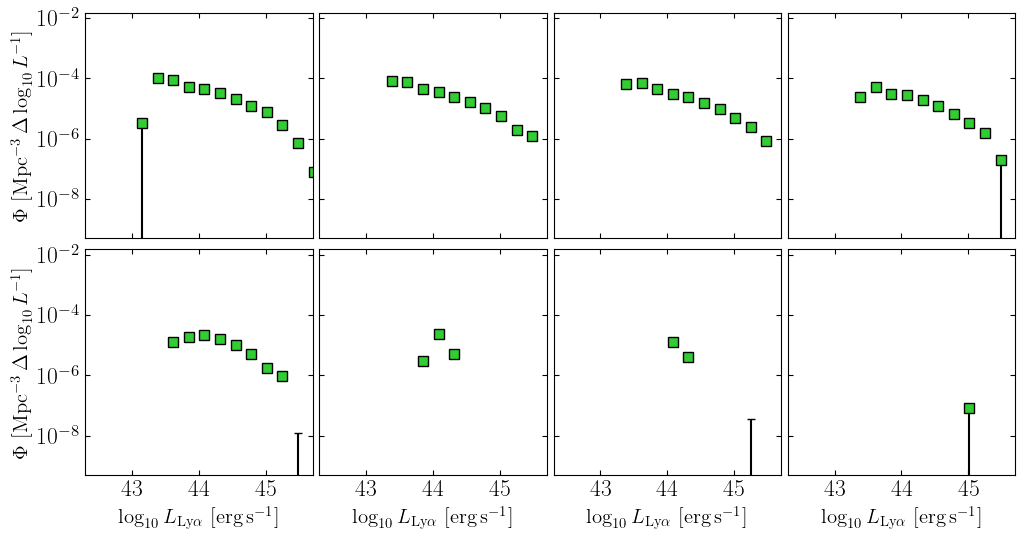

In [5]:
survey_list = ['SFG', 'QSO_cont', 'QSO_LAEs_loL',
               'GAL']
nb_list = [[0, 2], [2, 4], [4, 6], [6, 8],
           [8, 10], [10, 12], [12, 14], [14, 16]]

fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True,
                        width_ratios=[1, 1, 1, 1], height_ratios=[1, 1])

for iii, ax in enumerate(axs.flatten()):
    LyaLF = load_combined_LF(survey_list, [nb_list[iii]])

    ax.errorbar(LyaLF['LF_bins'], LyaLF['LF_total'],
                yerr=LyaLF['LF_total_err'],
                fmt='s', ls='', mfc='limegreen', mec='k',
                ms=7, ecolor='k', capsize=3)

    if iii >= axs.shape[1]:
        ax.set_xlabel(r'$\log_{10}L_{\mathrm{Ly}\alpha}$ [erg$\,$s$^{-1}$]', fontsize=15)
    if iii == 0 or iii == axs.shape[1]:
        ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}\,\Delta\log_{10}L^{-1}$]', fontsize=15)

    ax.set_ylim(0.5e-9, 1.5e-2)
    ax.set_xlim(42.3, 45.7)
    ax.set_yscale('log')

    ax.tick_params(labelsize=17, direction='in', which='both')
    ax.set_yticks(np.logspace(-8, -1, 8)[::2])
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    # ax.set_xticks(np.arange(42.5, 46, 0.5))

fig.subplots_adjust(wspace=0.03, hspace=0.05)
plt.show()

nb2-4


KeyError: 'zspec'

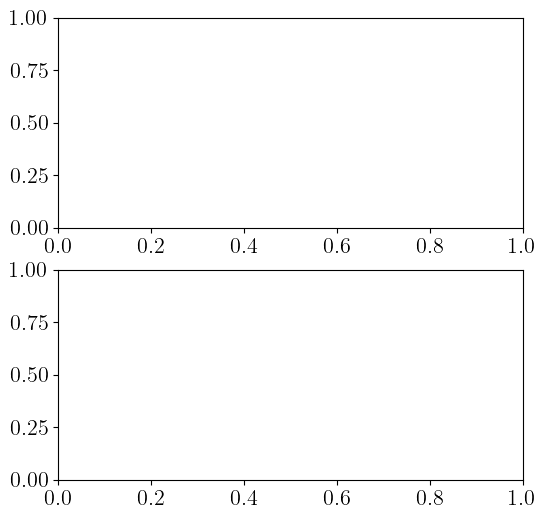

In [6]:
from plot.puricomp1D import main as plot_puricomp1d

nb_list = [[2, 4], [4, 6], [6, 8],
           [8, 10], [10, 12], [12, 14], [14, 16]]
r_min, r_max = 17, 24

fig, axs = plt.subplots(2, 1, figsize=(6, 6))

puricomp1d_L_bins = np.linspace(42.5, 45.5, 15)
puricomp1d_L_bins_c = bin_centers(puricomp1d_L_bins)

for jj, [nb_min, nb_max] in enumerate(nb_list):
    print(f'nb{nb_min}-{nb_max}')
    puri1d, comp1d, _ =\
        plot_puricomp1d('foo', nb_min, nb_max,
                        r_min, r_max, ax=None,
                        L_bins=puricomp1d_L_bins)[1:4]

    color = f'C{jj}'
    axs[0].plot(puricomp1d_L_bins_c, puri1d,
                label=f'NB: {nb_min}-{nb_max}',
                c=color)
    axs[1].plot(puricomp1d_L_bins_c, comp1d,
                c=color)

axs[0].legend()

plt.show()